In [47]:
# import libraries first
import duckdb
import pandas as pd 
import numpy as np 
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [48]:
# get your MotherDuck token from env
load_dotenv('.env')

token = os.getenv('motherduck_token')


In [49]:
# connect to the database
con = duckdb.connect(f"md:?motherduck_token={token}")

# define your SQL query
sql_query = "SELECT * FROM stocks_clouddb.msft_data"

# execute the query and fetch the result into a DataFrame
df = con.sql("SELECT * FROM stocks_clouddb.msft_data").fetchdf().copy()

In [50]:
# display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
             datetime  open_price  day_high   day_low  close_price  \
0 1986-03-12 21:00:00    0.055004  0.063093  0.055004     0.060396   
1 1986-03-13 21:00:00    0.060396  0.063632  0.060396     0.062553   
2 1986-03-16 21:00:00    0.062553  0.064172  0.062553     0.063632   
3 1986-03-17 21:00:00    0.063632  0.064172  0.061475     0.062014   
4 1986-03-18 21:00:00    0.062014  0.062553  0.060396     0.060936   

       volume  dividends  stock_splits  
0  1031788800        0.0           0.0  
1   308160000        0.0           0.0  
2   133171200        0.0           0.0  
3    67766400        0.0           0.0  
4    47894400        0.0           0.0  


In [51]:
df_close=df['close_price']

## ARIMA Model 

### Check for Stationarity of Time Series 

Before building the ARIMA (Auto Regression Integrated Moving Average) model to predict stock price, we need to check the stationarity of a time series by using the Augmented Dickey-Fuller(ADF) unit root test. The p-value resulting from the ADF test has to be less than 0.05 or 5% for a time series to be stationary. The charts helps us in identifying the patterns and variation in the data. From the following output, it showed the p-value is greater than 0.05 or 5%, which means it is non-stationar. 

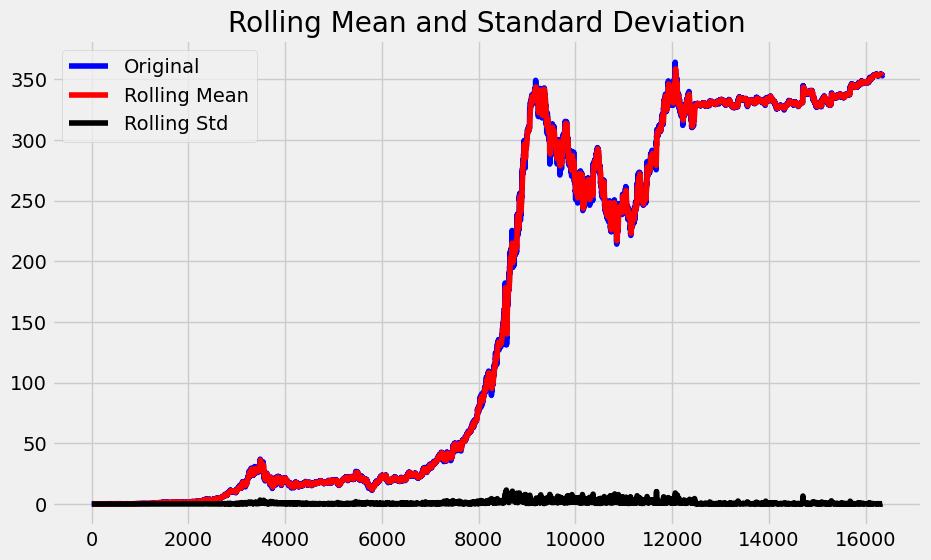

Results of Dickey fuller test
Test Statistics                   -0.103687
p-value                            0.949070
No. of lags used                  43.000000
Number of observations used    16301.000000
critical value (1%)               -3.430751
critical value (5%)               -2.861717
critical value (10%)              -2.566864
dtype: float64


In [52]:
def test_stationarity(timeseries):
    # determing rolling statistics 
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # plot rolling statistics 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black',label ='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of Dickey fuller test") 
    adft= adfuller(timeseries, autolag ='AIC')
    # output for dft won't define what the values are
    # hence we manually write what values does it explain using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)
   

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant. Let’s isolate the time series from the Trend and Seasonality.

<Figure size 1000x600 with 0 Axes>

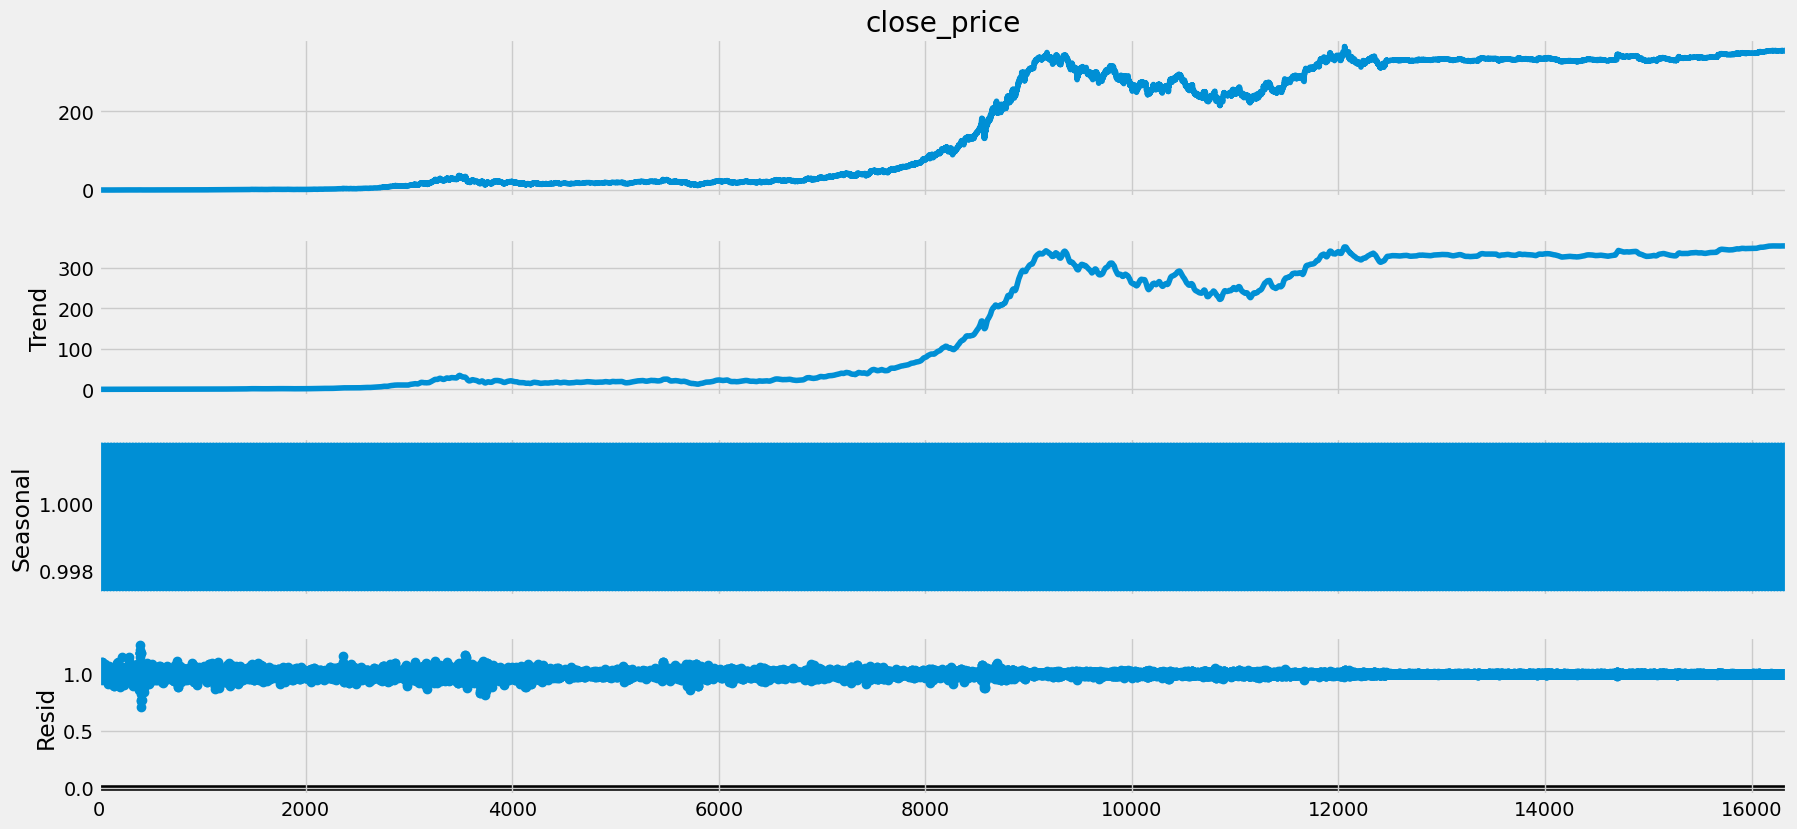

In [53]:
# to separate the trend and the seasonality from a time series
# decompose the series
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 9)

As it is non-stationary, we need to eliminate trend. To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.The moving average is used to smooth out short-term fluctuation in the data and highlight the underlying trend. It helps us identify long-term patterns and trends in the stock price. The standard deviation measures the dispersion of the data, which can guide the selection of ARIMA model parameters, such as the order of the autoregressive (AR) and moving average (MA) components. Low values suggest more stability, vice visa.  This chart help us assess trends, seasonality, and periods of high or low volatility in the data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


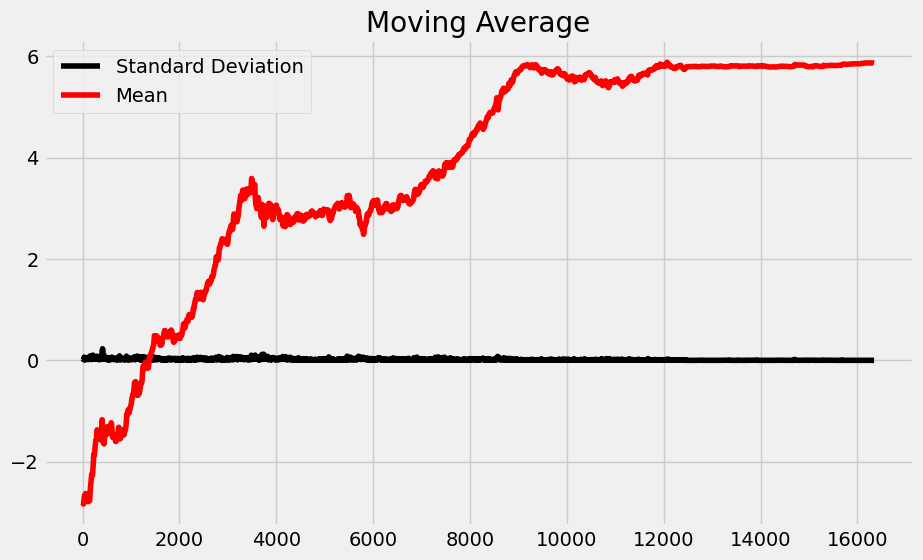

In [54]:
# if it's not stationary then eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### Training and Testing Data

Before developing an ARIMA model, we need to split the data into training and testing dataset to evaluate how well the ARIMA model performs in forecasting unseen future data. From the chart below, we could visualize these two datasets. After training an ARIMA model using the training data, we can use the testing data to make forecasts and compare them to the actual values. This will help us evaluate the model's ability to predict future stock prices accurately.

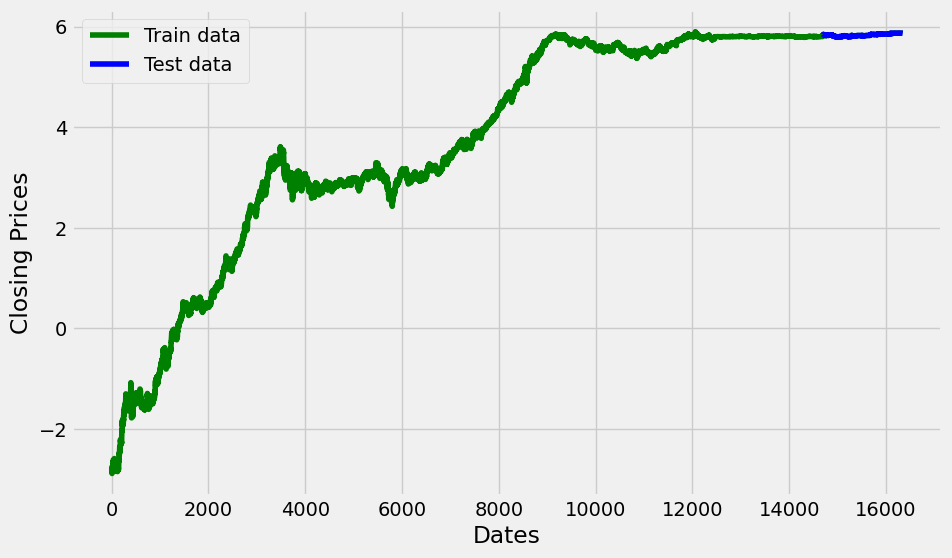

In [55]:
# split data into testing and training set and visualize it 
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### Auto ARIMA Model Development

We are going to use auto ARIMA automatically discover the optimal parameters for an ARIMA model.

The auro_arima function works by performing differencing tests (e.g., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller, or Phillips–Perron) to determine the order of differencing, d, and then fitting models within start p, max p, start q, max q ranges. After conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D, auto_arima also seeks to identify the optimal P and Q hyper-parameters if the seasonal option is enabled.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-77928.810, Time=3.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77931.269, Time=3.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77931.602, Time=8.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-77913.540, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77929.428, Time=4.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-77949.217, Time=4.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-77959.159, Time=6.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-77957.592, Time=5.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-77958.639, Time=6.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-77957.291, Time=5.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-77942.830, Time=4.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-77954.296, Time=8.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-77939.951, Time=2.27 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 64.277 sec

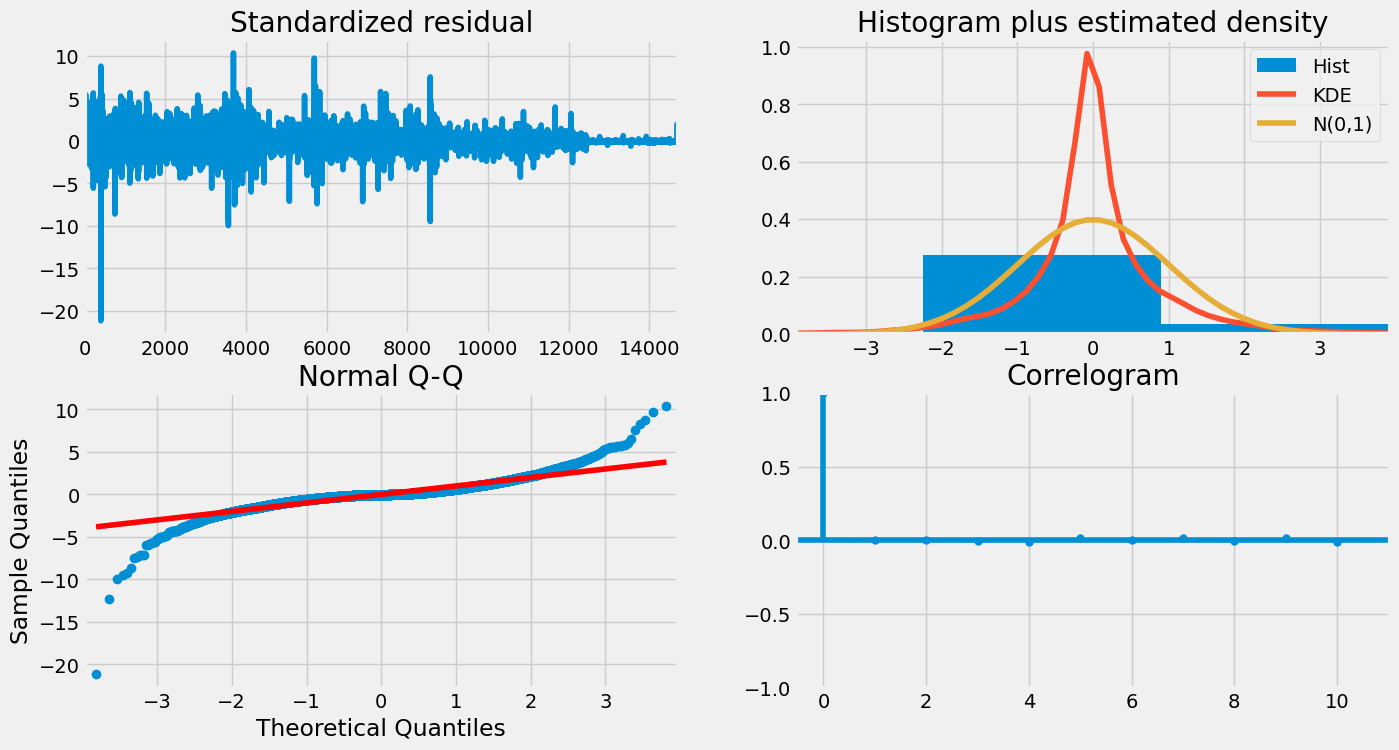

In [56]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(17,9))
plt.show()

The Auto ARIMA model assigned the values 1,1,and 2 to p, d and q respectively to build the model. 

In [57]:
# build model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            close_price   No. Observations:                14707
Model:                 ARIMA(1, 1, 2)   Log Likelihood               38973.976
Date:                Tue, 07 Nov 2023   AIC                         -77939.951
Time:                        13:15:10   BIC                         -77909.567
Sample:                             0   HQIC                        -77929.860
                              - 14707                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4906      0.079      6.207      0.000       0.336       0.646
ma.L1         -0.5092      0.079     -6.485      0.000      -0.663      -0.355
ma.L2         -0.0252      0.005     -5.539      0.0

Now, let's start forecasting stock prices on the test dataset with a 95% confident level. From the plot below, we can see that the predicted price is closely align with the actual price. 

c:\Users\Admin\miniconda3_Used_this_one\envs\pred-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


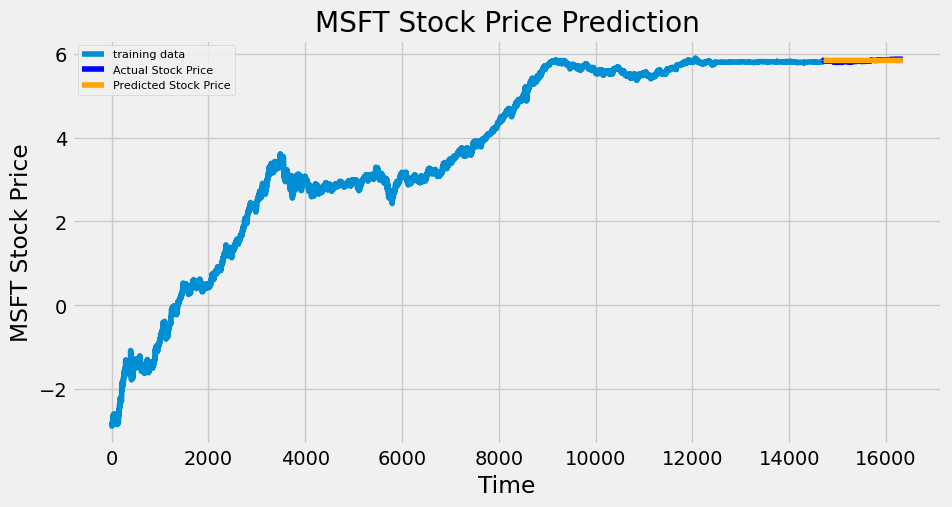

In [58]:
# forecast 

fc = fitted.forecast(steps=len(test_data), alpha=0.05) 
# make as pandas series
fc_series = pd.Series(fc, index=test_data.index)

# calculate the lower and upper bounds of the confidence interval manually
forecast_std = fitted.get_prediction(start=0, end=len(train_data) - 1).se_mean
alpha = 0.05  # 95% confidence interval
z = stats.norm.ppf(1 - alpha / 2)
lower_series = fc - z * forecast_std
upper_series = fc + z * forecast_std

lower_series = pd.Series(lower_series, index=test_data.index)
upper_series = pd.Series(upper_series, index=test_data.index)

# plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


### Metrics 

Let's look at some common accuracy metrics for evaluating forecast results. The low values for MSE, MAE, RMSE, and MAPE are generally indicative of a well-performing model. They suggest that your ARIMA model is making reasonably accurate forecasts for Microsoft's stock price.

In [59]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0005980778630609433
MAE: 0.021297357010278108
RMSE: 0.024455630498127486
MAPE: 0.0036565663707392496


## LSTM Model 

In [60]:
import tensorflow as tf
import sklearn 
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, LSTM
from sklearn.model_selection import TimeSeriesSplit

In [79]:
data = df.filter(['close_price'])
# convert the dataframe to a numpy array 
dataset = data.values 

# get the number of rows to train the model on 
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

13076

In [64]:
# scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[1.18476052e-05],
       [1.77714180e-05],
       [2.07350638e-05],
       ...,
       [9.68868801e-01],
       [9.69198364e-01],
       [9.68827564e-01]])

In [65]:
# create the scaled training dataset 
train_data = scaled_data[0:training_data_len, :]

# split the data into x_train and y_train dataset 
X_train=[]
y_train =[]

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    # set 60 as the time step 
    if i < 61: 
        print(X_train)
        print(y_train)
        print()

[array([1.18476052e-05, 1.77714180e-05, 2.07350638e-05, 1.62904137e-05,
       1.33285789e-05, 8.88565786e-06, 4.44281870e-06, 0.00000000e+00,
       2.96188595e-06, 7.40474557e-06, 1.03665804e-05, 8.88565786e-06,
       7.40474557e-06, 8.88565786e-06, 1.03665804e-05, 1.03665804e-05,
       7.40474557e-06, 8.88565786e-06, 1.18476052e-05, 1.33285789e-05,
       1.62904137e-05, 1.77714180e-05, 1.77714180e-05, 2.36969088e-05,
       2.51779029e-05, 1.92540083e-05, 1.92540083e-05, 1.62904137e-05,
       1.70309414e-05, 3.40636426e-05, 4.59128849e-05, 4.73937971e-05,
       4.14683268e-05, 3.70255081e-05, 3.40636426e-05, 3.40636426e-05,
       3.25826076e-05, 3.40636426e-05, 3.40636426e-05, 3.55444731e-05,
       3.40636426e-05, 3.55444731e-05, 3.70255081e-05, 3.55444731e-05,
       3.55444731e-05, 3.70255081e-05, 3.40636426e-05, 3.25826076e-05,
       2.96207830e-05, 2.96207830e-05, 2.96207830e-05, 3.55444731e-05,
       4.14683268e-05, 4.59128849e-05, 5.33177327e-05, 4.73937971e-05,
     

In [66]:
# convert the x_train and y_train to numpy arrays 
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape the data 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [70]:
# build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True , input_shape = (X_train.shape[1],1))) 
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# compile model 
model.compile(optimizer='adam', loss='mse')

# model training 
history = model.fit(X_train, y_train, epochs =25, batch_size = 8, verbose =1, shuffle = False)

Epoch 1/25
1627/1627 [==============================] - 71s 39ms/step - loss: 3.9246e-04
Epoch 2/25
1627/1627 [==============================] - 89s 55ms/step - loss: 0.0039
Epoch 3/25
1627/1627 [==============================] - 79s 48ms/step - loss: 0.0013
Epoch 4/25
1627/1627 [==============================] - 64s 39ms/step - loss: 8.7918e-04
Epoch 5/25
1627/1627 [==============================] - 61s 37ms/step - loss: 5.5879e-04
Epoch 6/25
1627/1627 [==============================] - 61s 37ms/step - loss: 3.8072e-04
Epoch 7/25
1627/1627 [==============================] - 59s 36ms/step - loss: 2.9436e-04
Epoch 8/25
1627/1627 [==============================] - 58s 36ms/step - loss: 2.6342e-04
Epoch 9/25
1627/1627 [==============================] - 63s 39ms/step - loss: 2.7825e-04
Epoch 10/25
1627/1627 [==============================] - 70s 43ms/step - loss: 2.6832e-04
Epoch 11/25
1627/1627 [==============================] - 64s 39ms/step - loss: 2.6794e-04
Epoch 12/25
1627/1627 [====

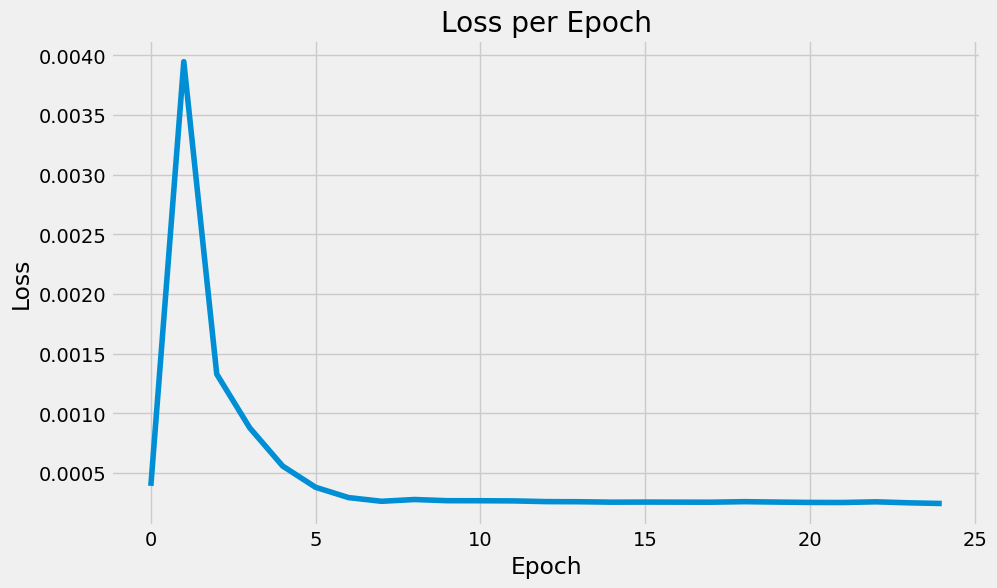

In [71]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

In [72]:
# create the testing dataset 
# create a new array containing scaled values 
test_data = scaled_data[training_data_len -60:, :]

# create the dataset x_test and y_test 
x_test =[]
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])


# convert the data to a numpy array
x_test = np.array(x_test )

# reshape the data 
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [75]:
# get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

103/103 [==============================] - 7s 30ms/step


In [76]:
# get the root mean squared error (RMSE)
rmse= np.sqrt(np.mean(predictions -y_test)**2) 
rmse 

2.2500674206023916

C:\Users\Admin\AppData\Local\Temp\ipykernel_21056\558192314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


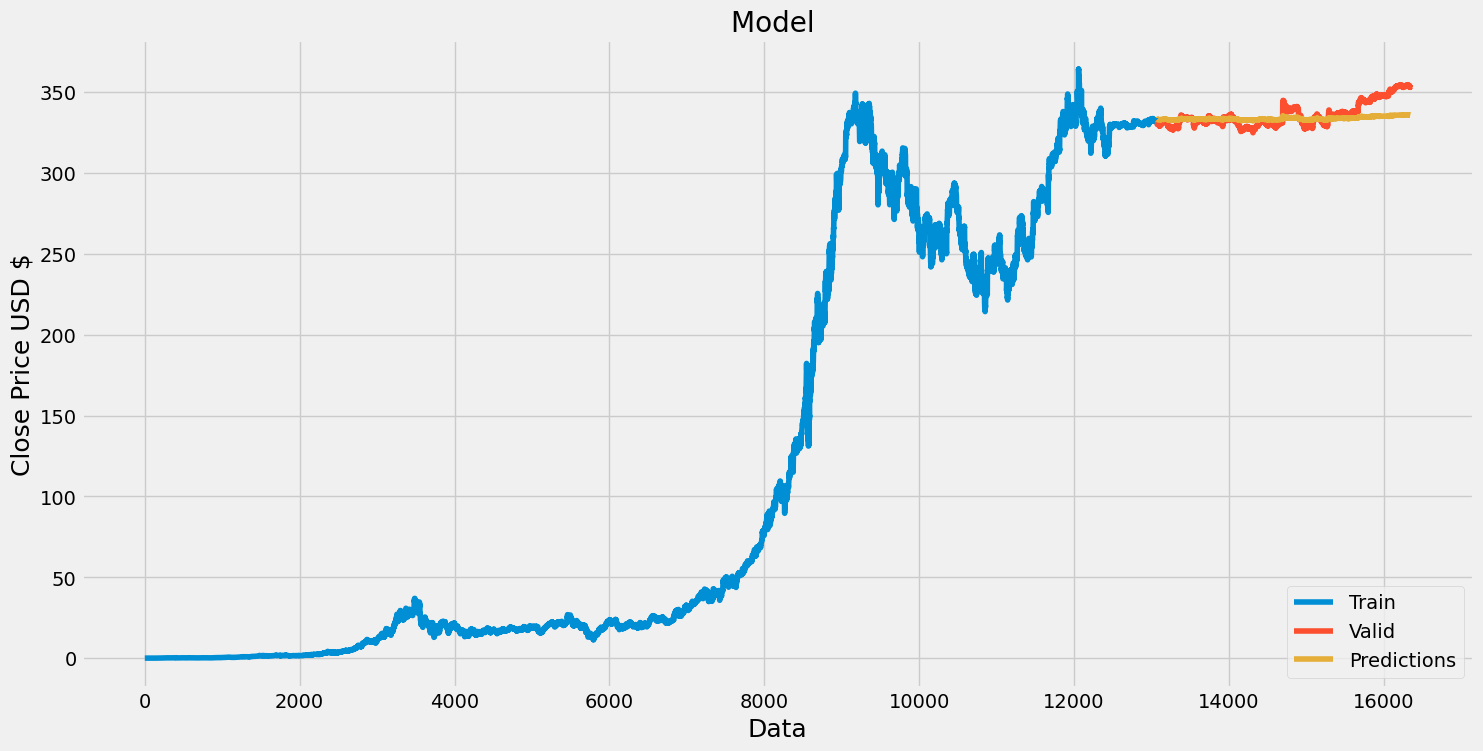

In [77]:
# plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions 

# visualize the data 
plt.figure (figsize = (16,8))
plt.title('Model ')
plt.xlabel('Data', fontsize =18)
plt.ylabel('Close Price USD $', fontsize=18)

plt.plot(train['close_price'])
plt.plot(valid[['close_price', 'Predictions']])
plt.legend(['Train','Valid','Predictions'], loc='lower right')
plt.show()

In [78]:
# show the valid and predicted prices 
valid

,close_price,Predictions
13076,330.260010,333.022644
13077,329.849792,332.974640
13078,329.989990,332.887482
13079,330.380005,332.901855
13080,330.689209,333.002380
...,...,...
16340,352.945007,335.604492
16341,353.220001,335.609070
16342,352.825012,335.651703
16343,352.945007,335.597351
